# Forecasting air pollution in London following the ULEZ expansion

The Ultra low emission zone (ULEZ) is a tax on high polluting vehicles first introduced in April 2019 on inner London boroughs. If you owned a non-compliant vehicle and entered the ULEZ zone, you would have to pay a charge. In 29 August 2023, this tax zone was expanded to cover all Greater London boroughs. This forecasting project seeks to understand how well LSTM can perform against standard ARIMA models, especially when responding to sudden changes in the time series

In [1]:
from pyaurn import importAURN, importMeta, timeAverage # air pollution data
import matplotlib.pyplot as plt
import pandas as pd
from datetime import datetime, date, time

In [11]:
# Get data from AURN
data = importAURN("CLL2", range(2022, 2025)) ## Try one for camden

In [12]:
# Process data to get daily sample
data = data.dropna(subset=['NO2']) ## drop NA data
data['date'] = pd.to_datetime(data['date'])
data = data.loc[data['date'].dt.time == time(12,00)] ## only get data for 12 noon

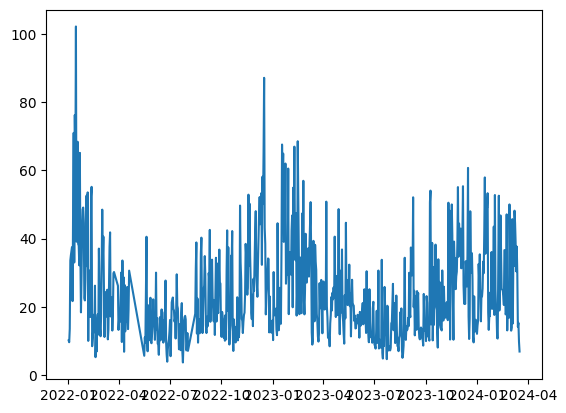

In [15]:
# Visualise the plot over time
data = data.set_index('date')
plt.plot(data.index, data['NO2'])

## Do preprocessing, create train and test

In [70]:
# Standardise data - similar to any ML problem, standardising data can improv predictions
from sklearn.preprocessing import MinMaxScaler
nox = data.loc[:, ['NOXasNO2']]
scaler = MinMaxScaler(feature_range=(0, 1))
nox[:] = scaler.fit_transform(nox) ## transform data, keep date index

In [198]:
# split into train and test sets
train_index, test_index = nox['20220101':'20231001'], nox['20231002':'20300101'] ## Rather than do % split, do train test by dates
print(len(train_index), len(test_index))

# Create a version without the index for the LSTM model
train, test = train_index.NOXasNO2.to_numpy(), test_index.NOXasNO2.to_numpy()
train.shape = (train.shape[0], 1) # Allocate 2d
test.shape = (test.shape[0], 1) # Allocate 2d

586 163


## LSTM approach

In [151]:
# convert an array of values into a dataset matrix
import numpy as np
def create_dataset(dataset, look_back=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-look_back-1):
		a = dataset[i:(i+look_back), 0]
		dataX.append(a)
		dataY.append(dataset[i + look_back, 0])
	return np.array(dataX), np.array(dataY)

In [152]:
# reshape into X=t and Y=t+1
look_back = 1
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

In [153]:
# reshape input to be [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

In [90]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.metrics import mean_squared_error

# create and fit the LSTM network
model = Sequential()
model.add(LSTM(4, input_shape=(1, look_back)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=100, batch_size=1, verbose=2)

2024-03-17 12:49:32.611275: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-03-17 12:50:34.443730: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Epoch 1/100
584/584 - 6s - loss: 0.0070 - 6s/epoch - 11ms/step
Epoch 2/100
584/584 - 4s - loss: 0.0063 - 4s/epoch - 6ms/step
Epoch 3/100
584/584 - 4s - loss: 0.0060 - 4s/epoch - 6ms/step
Epoch 4/100
584/584 - 3s - loss: 0.0058 - 3s/epoch - 6ms/step
Epoch 5/100
584/584 - 2s - loss: 0.0057 - 2s/epoch - 4ms/step
Epoch 6/100
584/584 - 3s - loss: 0.0057 - 3s/epoch - 5ms/step
Epoch 7/100
584/584 - 4s - loss: 0.0057 - 4s/epoch - 7ms/step
Epoch 8/100
584/584 - 4s - loss: 0.0057 - 4s/epoch - 7ms/step
Epoch 9/100
584/584 - 4s - loss: 0.0057 - 4s/epoch - 7ms/step
Epoch 10/100
584/584 - 3s - loss: 0.0056 - 3s/epoch - 5ms/step
Epoch 11/100
584/584 - 2s - loss: 0.0056 - 2s/epoch - 4ms/step
Epoch 12/100
584/584 - 4s - loss: 0.0056 - 4s/epoch - 6ms/step
Epoch 13/100
584/584 - 3s - loss: 0.0055 - 3s/epoch - 5ms/step
Epoch 14/100
584/584 - 3s - loss: 0.0056 - 3s/epoch - 5ms/step
Epoch 15/100
584/584 - 4s - loss: 0.0056 - 4s/epoch - 7ms/step
Epoch 16/100
584/584 - 4s - loss: 0.0056 - 4s/epoch - 7ms/step


In [154]:
import math

# make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])
# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

6/6 [==============================] - 0s 3ms/step
Train Score: 36.65 RMSE
Test Score: 34.22 RMSE


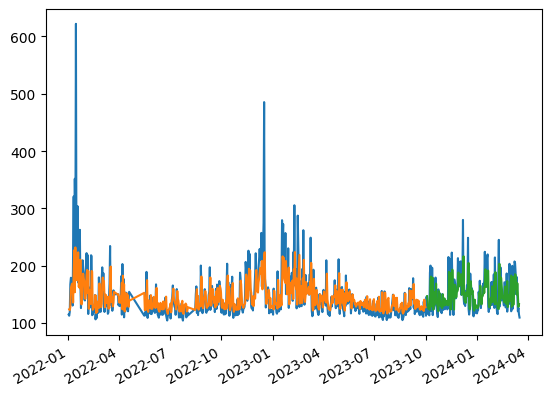

In [163]:
# shift train predictions for plotting
trainPredictPlot = np.empty_like(nox)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
trainPredictPlot = pd.DataFrame(data = {'predict': trainPredictPlot[:, 0]}, index=nox.index) # add in date index
# shift test predictions for plotting
testPredictPlot = np.empty_like(nox)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(nox)-1, :] = testPredict
testPredictPlot = pd.DataFrame(data = {'predict': testPredictPlot[:, 0]}, index=nox.index) # add in date index
# plot baseline and predictions
base_data = scaler.inverse_transform(nox)
base = pd.DataFrame(data = {'base': base_data[:, 0]}, index=nox.index) # add in date index

fig, ax = plt.subplots()
plt.plot(base.index, base['base'])
plt.plot(trainPredictPlot.index, trainPredictPlot['predict'])
plt.plot(testPredictPlot.index, testPredictPlot['predict'])
fig.autofmt_xdate()
plt.savefig('lstm_forecast.png')
plt.show()

## Baseline: AR(1) model

In [191]:
from statsmodels.tsa.arima.model import ARIMA
mod = ARIMA(train, order=(1, 0, 0))
model_fit = mod.fit()
coef = model_fit.params[0]
coef

0.07749985431345208

In [199]:
# Loop through AR(1) 1-step ahead forecasts
history = train
for t in range(len(test)):
    model_f = ARIMA(history, order=(1, 0, 0))
    model_fit_f = model_f.fit()
    yhat_f = model_fit_f.forecast()[0]
    history = np.append(history, yhat_f)

/Users/hiajoshua96/Desktop/air_pollution_forecast/venv/lib/python3.7/site-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/Users/hiajoshua96/Desktop/air_pollution_forecast/venv/lib/python3.7/site-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/Users/hiajoshua96/Desktop/air_pollution_forecast/venv/lib/python3.7/site-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/Users/hiajoshua96/Desktop/air_pollution_forecast/venv/lib/python3.7/site-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/Users/hiajoshua96/Desktop/air_pollution_forecast/venv/lib/python3.7/site-packages/statsmodels/b

In [235]:
test_index = len(train)
test_pred = history[test_index:]
test_pred = scaler.inverse_transform([test_pred])
test_pred = test_pred.transpose()
test_inv = scaler.inverse_transform(test)

mean_squared_error(test_inv, test_pred) ## MSE is 1129, way higher than LSTM

1129.3573819238584